This notebook is put together by [Zefeng Li](http://web.gps.caltech.edu/~zefengli/) from [Caltech Seismo Lab](http://www.seismolab.caltech.edu/) for the 2019 SSA Machine Learning workshop. If you have any questions, feel free to contact him via zefengli@caltech.edu. 

## Remarks
Supervised ML is basically to find a function f(X)= y that maps your input (X) to your output (y). In regression tasks, y is a continuous variable. There are a wide variety of choices for models f; you also have choices for the forms of input X (e.g. the objects themselves or the features of the objects). In the following, we introduce examples of magnitude estimation using early P waveforms.

In [1]:
# import all the needed module
import itertools
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import pandas as pd
from obspy import read
plt.style.use('seaborn-poster')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Prepare the training data

The first step is always reading in the data into a good format so that we can input into ML algorithms. 

In [2]:
training_folder = '../data/training_data_classification_regression/'
# prepare data
waveforms = []
labels = []

for item in glob.glob(training_folder + 'seismic/*.mseed'):
    
    st = read(item)
    st.detrend('demean').detrend('linear')
    data = np.c_[st[0].data, st[1].data, st[2].data]
    waveforms.append(data)
    
waveforms = np.dstack(waveforms)
waveforms = waveforms.T

In [3]:
waveforms.shape

(265, 3, 1626)

In [4]:
df = pd.read_csv(training_folder + 'EQs_M3_above.csv')

In [5]:
print(df[:3])

  network  stnm channel       dist phase                   phase_time onset  \
0      BK  MNRC     HHZ  31.757232     P  2005-07-23T12:31:34.290000Z   NaN   
1      BK  MNRC     HHZ  61.668538     P  2005-08-25T11:10:53.390000Z   NaN   
2      BK  MNRC     HHZ  33.505025     P  2005-08-29T02:36:31.350000Z   NaN   

   polarity evaluation_mode evaluation_status                       evtime  \
0  negative          manual             final  2005-07-23T12:31:27.830000Z   
1  positive          manual             final  2005-08-25T11:10:41.720000Z   
2  positive          manual             final  2005-08-29T02:36:24.670000Z   

        evla        evlo   mag mag_type   eventId  
0  38.796333 -122.793833  3.19       Ml  21471390  
1  38.362000 -122.185000  3.16       Ml  21479549  
2  38.817167 -122.821500  3.10       Ml  21480285  


In [6]:
y = df['mag']

In [7]:
y.shape

(265,)

## Let's see some examples of EQ waveforms

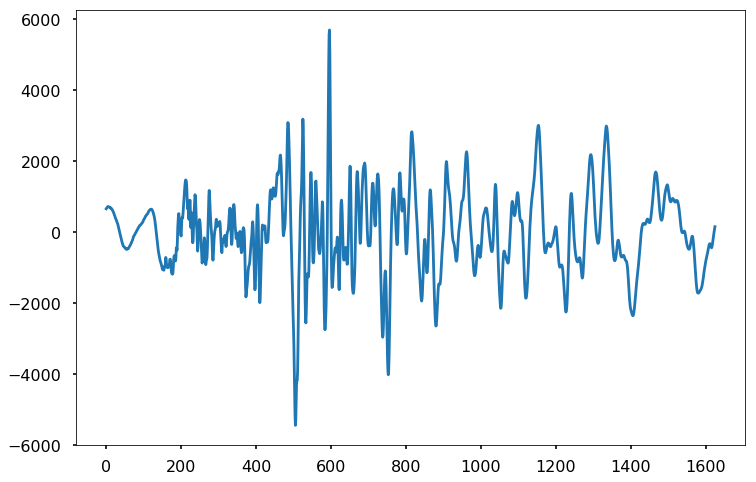

In [8]:
# Earthquake waveform examples
plt.figure(figsize = (12, 8))
plt.plot(waveforms[2, 1, :])

## Object Features vs. Objects themselves
There are basically two types of inputs: a. the features of the object; b. the objects themselves. Let's see the first case.

## Extract features

Let's first define a function to calculate just 4 features (of course, you can calculate more, we will only use these 4 features to illustrate the main ideas). These features such as mean value, max value, standard deviation, and number of zero crossings are calculated first on each of the 3 components, and then we only keep the largest one from the 3 components. 

In [9]:
def calculate_features(data):
    
    # Similar features
    mean_amp = np.apply_along_axis(np.mean, 1, np.abs(data))
    max_amp = np.apply_along_axis(max, 1, np.abs(data))
    std_amp = np.apply_along_axis(np.std, 1, data)
    
    # useful features
    zero_crossings = lambda data: len(np.where(np.diff(np.sign(data)))[0])
    zc = np.apply_along_axis(zero_crossings, 1, data)
    
    return np.log10(max(mean_amp)), np.log10(max(max_amp)), np.log10(max(std_amp)), max(zc)

In [10]:
# calculate all the features for each record
feature_names = ['mean_amp', 'max_amp', 'std_amp', 'zc']
X = np.array(list(map(calculate_features, waveforms)))
print(X.shape)

(265, 4)


Text(0, 0.5, 'Mag')

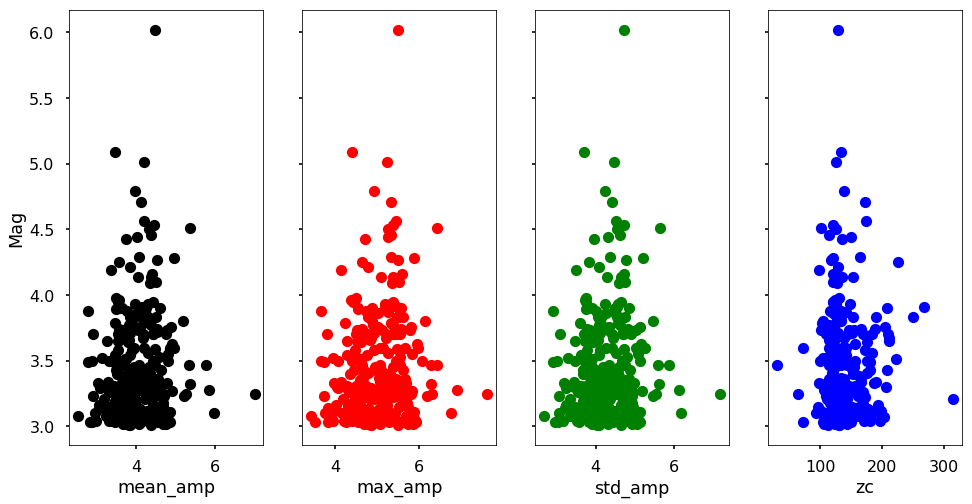

In [11]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize = (16, 8))
for i, c in zip([0, 1, 2, 3], ['k', 'r', 'g', 'b']):
    axs[i].plot(X[:, i], y, 'o', color = c)
    axs[i].set_xlabel(feature_names[i])
axs[0].set_ylabel('Mag')

## Divide training/testing dataset and preprocessing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [13]:
print(len(X_train), len(X_test))

212 53


In [14]:
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)
print(X_train_scale.shape)

(212, 4)


Text(0, 0.5, 'mag')

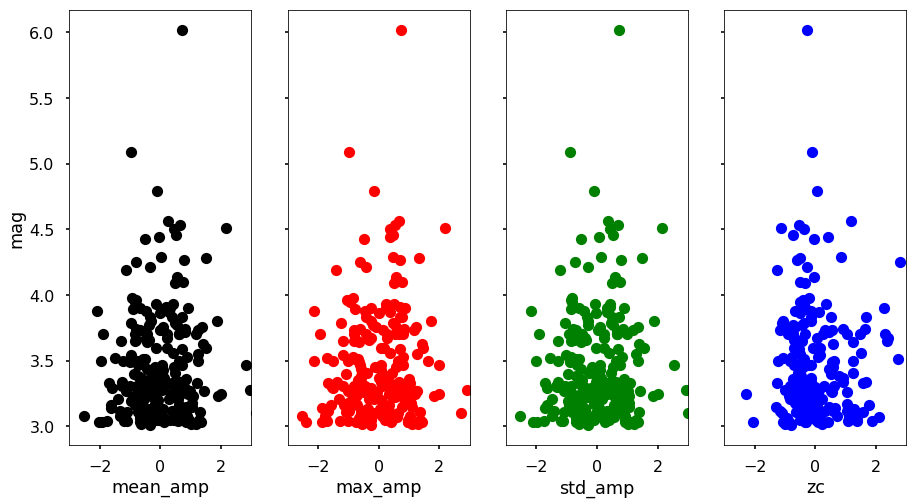

In [15]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize = (15, 8))
for i, c in zip([0, 1, 2, 3], ['k', 'r', 'g', 'b']):
    axs[i].plot(X_train_scale[:, i], y_train, 'o', color = c)
    axs[i].set_xlim([-3, 3])
    axs[i].set_xlabel(feature_names[i])
axs[0].set_ylabel('mag')

## Feature selection

There are different ways to select the best subset of the features, for example, scikit-learn has various [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods that you can easily use for your purposes. Here we will show how we can select the subset number of features achieve our goal. 

In [16]:
from sklearn.feature_selection import mutual_info_regression, RFECV
mi = mutual_info_regression(X_train_scale, y_train)

In [17]:
print(mi)
print(X_train_scale.shape)

[0 0 0 0]
(212, 4)


In [18]:
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_ 

array([ True,  True,  True,  True], dtype=bool)

In [19]:
selector.ranking_

array([1, 1, 1, 1])

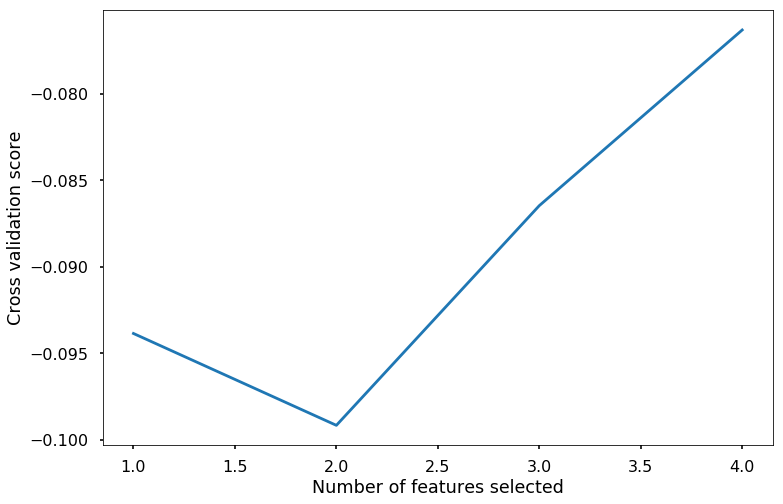

In [20]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize = (12, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

## Train an Random Forest model

### Turning hyperparameters

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
# Use all the features, scale input
X_train_scale = standard_scaler.fit_transform(X_train)
X_test_scale = standard_scaler.transform(X_test)

In [23]:
# Set the parameters by cross-validation
n_estimators = [10, 20, 40, 80]
max_depth =[5, 10, 20, 40]

In [24]:
print("# Tuning hyper-parameters:")
for i_estimators in [10, 20, 50, 100]:
    for i_max_depth in [10, 20, 50]:
        regr = RandomForestRegressor(n_estimators=i_estimators, 
                                    max_depth=i_max_depth, 
                                    random_state=0, 
                                    criterion='mse')
        regr.fit(X_train_scale, y_train)
        print('n_estimators = {}, max_depth = {}'.format(i_estimators, i_max_depth))
        print('score on test set: {}'.format(regr.score(X_test_scale, y_test)))
        print('feature importances: {}'.format(regr.feature_importances_))
        print()


# Tuning hyper-parameters:
n_estimators = 10, max_depth = 10
score on test set: -0.047837551828579405
feature importances: [ 0.28637884  0.26116826  0.2014233   0.25102959]

n_estimators = 10, max_depth = 20
score on test set: -0.04069413250982579
feature importances: [ 0.27525385  0.27335277  0.19041386  0.26097952]

n_estimators = 10, max_depth = 50
score on test set: -0.04069413250982579
feature importances: [ 0.27525385  0.27335277  0.19041386  0.26097952]

n_estimators = 20, max_depth = 10
score on test set: 0.008447808880596264
feature importances: [ 0.2731043   0.32156595  0.18461469  0.22071506]

n_estimators = 20, max_depth = 20
score on test set: 0.03032728657386852
feature importances: [ 0.24565333  0.3175085   0.21073519  0.22610298]

n_estimators = 20, max_depth = 50
score on test set: 0.03032728657386852
feature importances: [ 0.24565333  0.3175085   0.21073519  0.22610298]

n_estimators = 50, max_depth = 10
score on test set: 0.018470915194715998
feature importances: [ 0

## Train and Test the RF model

In [25]:
regr = RandomForestRegressor(n_estimators=50, 
                             max_depth=20, 
                             random_state=0, 
                             criterion='mse')
regr.fit(X_train_scale, y_train)
y_pred = regr.predict(X_test_scale)

Text(0, 0.5, 'y_pred')

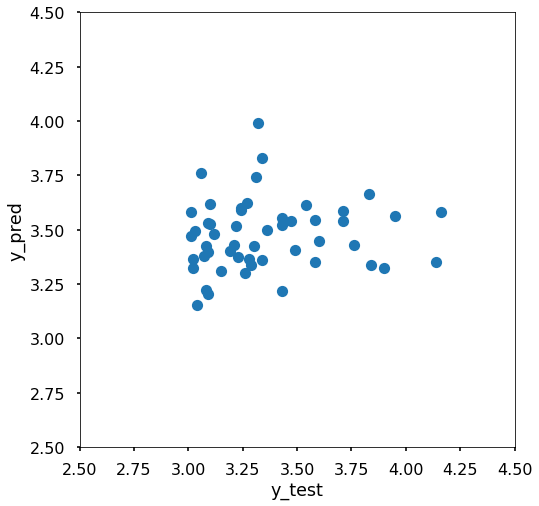

In [26]:
plt.figure(figsize = (12, 8))
plt.plot(y_test, y_pred, 'o')
plt.axis('square')
plt.xlim([2.5, 4.5])
plt.ylim([2.5, 4.5])
plt.xlabel('y_test')
plt.ylabel('y_pred')

Text(0.5, 0, 'y residual')

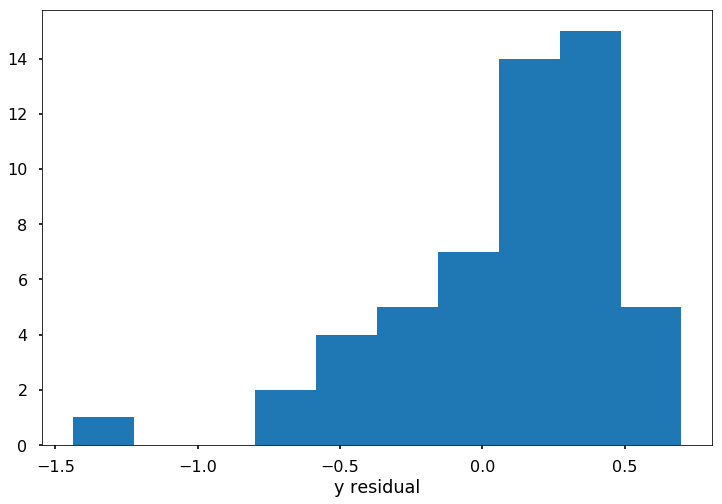

In [27]:
plt.figure(figsize = (12, 8))
plt.hist(y_pred-y_test)
plt.xlabel('y residual')

## Feeding waveforms directly to Deep learning 

In [28]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [29]:
X = waveforms
standard_scaler = StandardScaler()
for i in range(X.shape[0]):
    X[i] = X[i]/np.max(np.std(X[i]))

In [30]:
X.shape

(265, 3, 1626)

In [31]:
y.shape

(265,)

In [32]:
# input image dimensions
img_rows, img_cols = 3, 1626

In [33]:
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [34]:
X.shape

(265, 3, 1626, 1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [36]:
# define the model

inputs = Input(input_shape)
x = Conv2D(8, (1, 3), activation='relu')(inputs)
x = MaxPooling2D((1, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 1626, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 1624, 8)        32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 812, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 812, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                311824    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
__________

In [37]:
batch_size = 8
epochs = 50

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mse'])

# use 20% of the training data as validation
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)

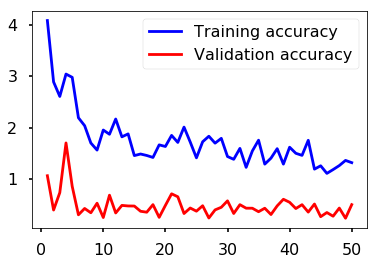

In [38]:
mse = history.history['loss']
val_mse = history.history['val_loss']
epochs_axis = range(1, len(mse) + 1)
plt.plot(epochs_axis, mse, 'b', label='Training accuracy')
plt.plot(epochs_axis, val_mse, 'r', label='Validation accuracy')
plt.legend()

In [39]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'y_pred')

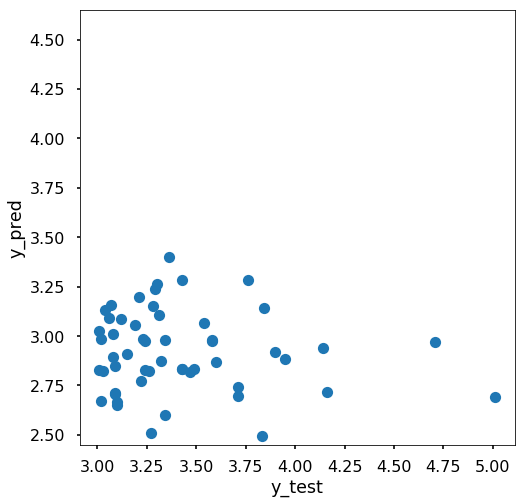

In [40]:
plt.figure(figsize = (12, 8))
plt.plot(y_test, y_pred, 'o')
plt.axis('square')
#plt.xlim([2.5, 4.5])
#plt.ylim([2.5, 4.5])
plt.xlabel('y_test')
plt.ylabel('y_pred')